In [1]:
import numpy as np
import matplotlib.pyplot as plt

The network consists of a single layer of 180 neurons that receive activation from both exogenous inputs and lateral connections.

### Input activation
#### equation (7)

On simulated trial *n*, the mean input activation to neuron *i* is a function of the difference between the target location *$\theta(n)$* and the preferred direction of the neuron *$\theta_i^*$*


I_i: *$I_i(n)$*, mean activation of unit i  
I_0: *$I_0$*, baseline input rate  
gamma: *$\gamma$*, input gain  
theta: *$\theta(n)$*,  target location  
theta_star_i: *$\theta_i^*$*, prefered direction of unit i  
w: *$\omega_i$*, spread of input activation (full-width-half-magnitude)  


In [ ]:
#I_0 = ???
#gamma = ???
#w = ???

#I_i = I_0 + gamma * np.exp(-np.log(2)((theta-theta_star_i) / (w/2)))**2


In [ ]:
# define input activation function

def input_activation(target, preference, baseline=0, gain=1, spread=2):
    activation = baseline + gain * np.exp(-np.log(2) * ((target-preference) / (spread/2))**2)    
    return activation

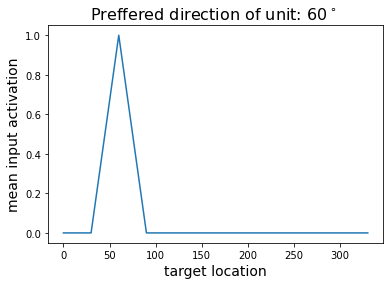

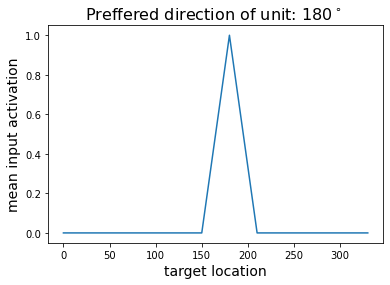

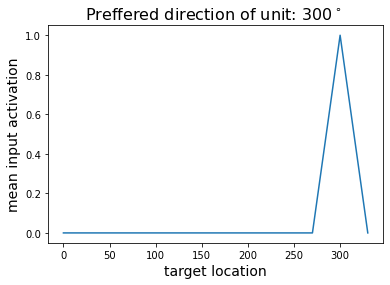

In [17]:
# Plot activation profile for and example unit

def plot_input_activation_profile(prefered_direction):
    # calculate activation for all orientations between 0 and 360 degrees
    target = np.arange(0,360,30)
    N = len(target)
    activation = np.zeros(N)

    for ii in range(N):
        activation[ii] = input_activation(target[ii], prefered_direction)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(target, activation)
    plt.xlabel('target location', fontsize=14)
    plt.ylabel('mean input activation', fontsize=14)
    plt.title('Preffered direction of unit: %d$^\circ$ ' %prefered_direction, fontsize=16)
    
for pref in[60, 180, 300]:
    plot_input_activation_profile(pref)

### Trial iteration
#### equation (8)

For network simulations, the dynamics of the network were iterated five times for each trial.

[*I think we can consider leaving this iteration detail out to begin with. This will also simplify equations 10 and 11]

### Lateral connection strength
#### equation (9)

The initial connection strength between a pair of units is determined by the distance between the units’ preferred directions in the circular space (preferred directions were evenly spaced at delta = 2 degrees)

In [ ]:
# theta_star_i: prefered direction of unit i
# theta_star_i: prefered direction of unit j
# w_L: WFHM

w+L = ???

W_ij = np.exp(-np.log(2)((theta_star_i-theta_star_j) / (w_L/2))**2)

### Total Activation
#### equation (10) and equation (11)

On each iteration *t*, the total activation for unit *i* was then computed as the sum of the input and recurrent activations: equation (10)
Total activation was normalized on each iteration to obtain the new firing rates: equation(11)

[*as noted before, I will begin without the iteration process]

In [ ]:
# X_i: new firing rate for unit i

# input activation
#    I_i: equation (7)
# recurant acivation
#    W_ij: synaptic weights; initially set with equation (9) and updated with equation (12)
#    X: firing rate of neighboring neurons on previous trial (initial rates = 0)

X_i = I_i + W_ij .* X

### Hebbian learning rule
#### equation (12) 

After each iteration, the recurrent weights Wij were updated using a
normalized Hebbian learning rule [(Oja, 1982)](https://link.springer.com/article/10.1007/BF00275687)

In [ ]:
# B: learning rate
# a: normalization parameter
# W_ij: synaptic weights
# W_ij_t1: W_ij,t+1; updated weight

B = ???
a = ???

W_ij_t1 = W_ij + B()

### Estimated Movement Vector
#### equation (13) 

[Georgopoulos, 1988](https://www.jneurosci.org/content/8/8/2928)

In [ ]:
theta_mv = np.arctan(np.sum(np.cos(theta_star_i .- np.sin(theta_star_i))))